In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
#!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
#!git clone https://github.com/tensorflow/examples.git

In [3]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [38]:
#data_path = '/home/halde/cs229-falldetection/data_clean.csv'
#labels_path = '/home/halde/cs229-falldetection/processedLabels.csv'
data_path = '/home/shellygoel2324/data_merged.csv'

In [39]:
'''
def load_pose_landmarks(csv_path, labels_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    labels = pd.read_csv(labels_path, header=None)
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')

    # Extract the labels
    y = labels
    classes = range(8)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)
    
    return X, y, classes, dataframe
    
'''

def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    
    labels = dataframe["label"] - 1#pd.read_csv(labels_path, header=None)
    
    print(labels.unique())
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')
    df_to_process.pop('label')

    # Extract the labels
    y = labels
    classes = range(6)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [40]:
# Load the train data
#X, y, class_names, _ = load_pose_landmarks(data_path, labels_path)
#print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path)

print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

[0. 3. 1. 2. 4. 5.]
(12056, 51) (12056, 6)


In [41]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(0,6):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(0,6):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION
0: 0.5412691829116549
1: 0.25964330153463294
2: 0.11406055578598093
3: 0.047698050601410205
4: 0.02789299046038988
5: 0.009435918705931148

TEST DISTRIBUTION
0: 0.5655058043117744
1: 0.2462686567164179
2: 0.11525704809286899
3: 0.0472636815920398
4: 0.02155887230514096
5: 0.0041459369817578775


In [42]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.88208077 0.4231284  0.18587909 0.07773126 0.04545589 0.01537727]
[1.1336830354812486, 2.3633488199728907, 5.379841313829198, 12.86483792437417, 21.99935109744282, 65.03104884848482]


In [43]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## No normalizing at all

In [45]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = no_normalization(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 51)]              0         
                                                                 
 reshape_3 (Reshape)         (None, 17, 3)             0         
                                                                 
 tf.__operators__.getitem_3   (None, 17, 2)            0         
 (SlicingOpLambda)                                               
                                                                 
 flatten_3 (Flatten)         (None, 34)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               4480      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                           

In [46]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [47]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path` = "weights.best.hdf5"

checkpoint_path = "weights.best.801010split"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training


history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
603/603 [==============================] - ETA: 0s - loss: 2.0936 - tp: 3045.0000 - fp: 3549.0000 - tn: 44671.0000 - fn: 6599.0000 - accuracy: 0.8246 - precision: 0.4618 - recall: 0.3157 - auc: 0.7622 - prc: 0.3766
Epoch 1: val_loss improved from inf to 1.14941, saving model to weights.best.801010split
INFO:tensorflow:Assets written to: weights.best.801010split/assets
603/603 [==============================] - 5s 5ms/step - loss: 2.0936 - tp: 3045.0000 - fp: 3549.0000 - tn: 44671.0000 - fn: 6599.0000 - accuracy: 0.8246 - precision: 0.4618 - recall: 0.3157 - auc: 0.7622 - prc: 0.3766 - val_loss: 1.1494 - val_tp: 627.0000 - val_fp: 444.0000 - val_tn: 5586.0000 - val_fn: 579.0000 - val_accuracy: 0.8586 - val_precision: 0.5854 - val_recall: 0.5199 - val_auc: 0.8792 - val_prc: 0.6376
Epoch 2/200
601/603 [============================>.] - ETA: 0s - loss: 1.2669 - tp: 3085.0000 - fp: 2145.0000 - tn: 45935.0000 - fn: 6531.0000 - accuracy: 0.8496 - precision: 0.5899 - recall: 0.3208

Epoch 12/200
593/603 [============================>.] - ETA: 0s - loss: 0.9973 - tp: 4037.0000 - fp: 1139.0000 - tn: 46301.0000 - fn: 5451.0000 - accuracy: 0.8842 - precision: 0.7799 - recall: 0.4255 - auc: 0.9003 - prc: 0.6850
Epoch 12: val_loss did not improve from 0.79982
603/603 [==============================] - 1s 2ms/step - loss: 0.9998 - tp: 4099.0000 - fp: 1165.0000 - tn: 47055.0000 - fn: 5545.0000 - accuracy: 0.8840 - precision: 0.7787 - recall: 0.4250 - auc: 0.8998 - prc: 0.6836 - val_loss: 0.8631 - val_tp: 652.0000 - val_fp: 249.0000 - val_tn: 5781.0000 - val_fn: 554.0000 - val_accuracy: 0.8890 - val_precision: 0.7236 - val_recall: 0.5406 - val_auc: 0.9248 - val_prc: 0.7631
Epoch 13/200
601/603 [============================>.] - ETA: 0s - loss: 0.9963 - tp: 4225.0000 - fp: 1231.0000 - tn: 46849.0000 - fn: 5391.0000 - accuracy: 0.8852 - precision: 0.7744 - recall: 0.4394 - auc: 0.9005 - prc: 0.6847
Epoch 13: val_loss improved from 0.79982 to 0.79931, saving model to weights.

596/603 [============================>.] - ETA: 0s - loss: 0.9613 - tp: 4433.0000 - fp: 1190.0000 - tn: 46490.0000 - fn: 5103.0000 - accuracy: 0.8900 - precision: 0.7884 - recall: 0.4649 - auc: 0.9073 - prc: 0.7089
Epoch 23: val_loss did not improve from 0.75160
603/603 [==============================] - 1s 2ms/step - loss: 0.9565 - tp: 4508.0000 - fp: 1198.0000 - tn: 47022.0000 - fn: 5136.0000 - accuracy: 0.8905 - precision: 0.7900 - recall: 0.4674 - auc: 0.9082 - prc: 0.7114 - val_loss: 0.7582 - val_tp: 558.0000 - val_fp: 57.0000 - val_tn: 5973.0000 - val_fn: 648.0000 - val_accuracy: 0.9026 - val_precision: 0.9073 - val_recall: 0.4627 - val_auc: 0.9444 - val_prc: 0.8119
Epoch 24/200
600/603 [============================>.] - ETA: 0s - loss: 0.9294 - tp: 4607.0000 - fp: 1070.0000 - tn: 46930.0000 - fn: 4993.0000 - accuracy: 0.8947 - precision: 0.8115 - recall: 0.4799 - auc: 0.9135 - prc: 0.7265
Epoch 24: val_loss did not improve from 0.75160
603/603 [==============================] - 

Epoch 35/200
594/603 [============================>.] - ETA: 0s - loss: 0.9609 - tp: 4293.0000 - fp: 1058.0000 - tn: 46462.0000 - fn: 5211.0000 - accuracy: 0.8901 - precision: 0.8023 - recall: 0.4517 - auc: 0.9071 - prc: 0.7140
Epoch 35: val_loss did not improve from 0.73812
603/603 [==============================] - 1s 2ms/step - loss: 0.9603 - tp: 4366.0000 - fp: 1077.0000 - tn: 47143.0000 - fn: 5278.0000 - accuracy: 0.8902 - precision: 0.8021 - recall: 0.4527 - auc: 0.9072 - prc: 0.7144 - val_loss: 0.7870 - val_tp: 572.0000 - val_fp: 171.0000 - val_tn: 5859.0000 - val_fn: 634.0000 - val_accuracy: 0.8888 - val_precision: 0.7699 - val_recall: 0.4743 - val_auc: 0.9398 - val_prc: 0.7941
Epoch 36/200
596/603 [============================>.] - ETA: 0s - loss: 0.9420 - tp: 4608.0000 - fp: 1130.0000 - tn: 46550.0000 - fn: 4928.0000 - accuracy: 0.8941 - precision: 0.8031 - recall: 0.4832 - auc: 0.9113 - prc: 0.7227
Epoch 36: val_loss did not improve from 0.73812
603/603 [====================

Epoch 47/200
600/603 [============================>.] - ETA: 0s - loss: 0.9387 - tp: 4417.0000 - fp: 1059.0000 - tn: 46941.0000 - fn: 5183.0000 - accuracy: 0.8916 - precision: 0.8066 - recall: 0.4601 - auc: 0.9116 - prc: 0.7205
Epoch 47: val_loss did not improve from 0.70679
603/603 [==============================] - 1s 2ms/step - loss: 0.9377 - tp: 4442.0000 - fp: 1064.0000 - tn: 47156.0000 - fn: 5202.0000 - accuracy: 0.8917 - precision: 0.8068 - recall: 0.4606 - auc: 0.9118 - prc: 0.7211 - val_loss: 0.7212 - val_tp: 607.0000 - val_fp: 89.0000 - val_tn: 5941.0000 - val_fn: 599.0000 - val_accuracy: 0.9049 - val_precision: 0.8721 - val_recall: 0.5033 - val_auc: 0.9489 - val_prc: 0.8232
Epoch 48/200
601/603 [============================>.] - ETA: 0s - loss: 0.9248 - tp: 4747.0000 - fp: 1183.0000 - tn: 46897.0000 - fn: 4869.0000 - accuracy: 0.8951 - precision: 0.8005 - recall: 0.4937 - auc: 0.9139 - prc: 0.7305
Epoch 48: val_loss did not improve from 0.70679
603/603 [=====================

Epoch 59/200
599/603 [============================>.] - ETA: 0s - loss: 0.9130 - tp: 4639.0000 - fp: 1125.0000 - tn: 46795.0000 - fn: 4945.0000 - accuracy: 0.8944 - precision: 0.8048 - recall: 0.4840 - auc: 0.9155 - prc: 0.7317
Epoch 59: val_loss did not improve from 0.70679
603/603 [==============================] - 1s 2ms/step - loss: 0.9118 - tp: 4673.0000 - fp: 1132.0000 - tn: 47088.0000 - fn: 4971.0000 - accuracy: 0.8945 - precision: 0.8050 - recall: 0.4845 - auc: 0.9157 - prc: 0.7321 - val_loss: 0.7319 - val_tp: 610.0000 - val_fp: 89.0000 - val_tn: 5941.0000 - val_fn: 596.0000 - val_accuracy: 0.9053 - val_precision: 0.8727 - val_recall: 0.5058 - val_auc: 0.9478 - val_prc: 0.8232
Epoch 60/200
602/603 [============================>.] - ETA: 0s - loss: 0.9134 - tp: 4693.0000 - fp: 1091.0000 - tn: 47069.0000 - fn: 4939.0000 - accuracy: 0.8957 - precision: 0.8114 - recall: 0.4872 - auc: 0.9158 - prc: 0.7329
Epoch 60: val_loss did not improve from 0.70679
603/603 [=====================

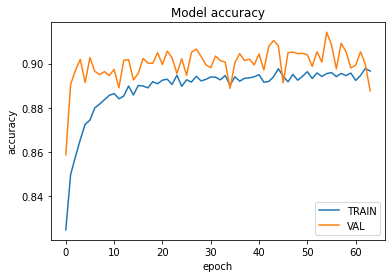

In [48]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

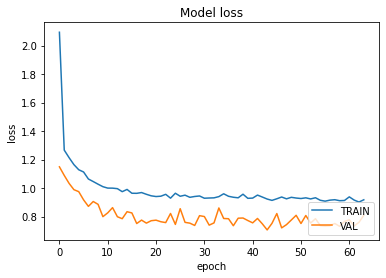

In [49]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [50]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

38/38 [==============================] - 0s 2ms/step - loss: 0.8451 - tp: 468.0000 - fp: 77.0000 - tn: 5953.0000 - fn: 738.0000 - accuracy: 0.8874 - precision: 0.8587 - recall: 0.3881 - auc: 0.9253 - prc: 0.7468


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.70      0.81       682
           1       0.41      0.97      0.57       297
           2       0.00      0.00      0.00       139
           3       0.00      0.00      0.00        57
           4       0.00      0.00      0.00        26
           5       0.00      0.00      0.00         5

    accuracy                           0.63      1206
   macro avg       0.23      0.28      0.23      1206
weighted avg       0.64      0.63      0.60      1206



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


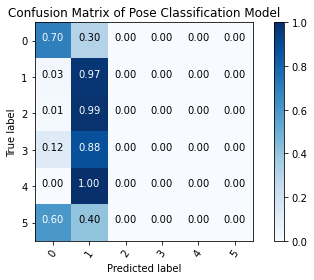

In [51]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

## Normalize everything

In [52]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_4 (Reshape)            (None, 17, 3)        0           ['input_5[0][0]']                
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 17, 2)       0           ['reshape_4[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_11 (TFOpLa  (None, 2)           0           ['tf.__operators__.getitem_

 a)                                                                                               
                                                                                                  
 tf.math.multiply_14 (TFOpLambd  (None, 2)           0           ['tf.compat.v1.gather_14[0][0]'] 
 a)                                                                                               
                                                                                                  
 tf.broadcast_to_4 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_4[0][0]',       
                                                                  'tf.compat.v1.floor_div_4[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_7 (TFOpLa  (None, 2)           0           ['tf.math.multiply_15[0][0]',    
 mbda)    

In [53]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path` = "weights.best.hdf5"

checkpoint_path = "weights.best.801010split"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training


history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
590/603 [============================>.] - ETA: 0s - loss: 0.8903 - tp: 5659.0000 - fp: 1350.0000 - tn: 51880.0000 - fn: 4987.0000 - accuracy: 0.9008 - precision: 0.8074 - recall: 0.5316 - auc: 0.9230 - prc: 0.7664
Epoch 1: val_loss improved from inf to 0.54413, saving model to weights.best.801010split
INFO:tensorflow:Assets written to: weights.best.801010split/assets
603/603 [==============================] - 7s 7ms/step - loss: 0.8853 - tp: 5812.0000 - fp: 1376.0000 - tn: 52874.0000 - fn: 5038.0000 - accuracy: 0.9015 - precision: 0.8086 - recall: 0.5357 - auc: 0.9237 - prc: 0.7684 - val_loss: 0.5441 - val_tp: 957.0000 - val_fp: 143.0000 - val_tn: 5887.0000 - val_fn: 249.0000 - val_accuracy: 0.9458 - val_precision: 0.8700 - val_recall: 0.7935 - val_auc: 0.9711 - val_prc: 0.9023
Epoch 2/200
591/603 [============================>.] - ETA: 0s - loss: 0.5953 - tp: 7076.0000 - fp: 1214.0000 - tn: 46066.0000 - fn: 2380.0000 - accuracy: 0.9367 - precision: 0.8536 - recall: 0.7483

603/603 [==============================] - 3s 5ms/step - loss: 0.3976 - tp: 8008.0000 - fp: 910.0000 - tn: 47310.0000 - fn: 1636.0000 - accuracy: 0.9560 - precision: 0.8980 - recall: 0.8304 - auc: 0.9827 - prc: 0.9373 - val_loss: 0.3209 - val_tp: 1041.0000 - val_fp: 91.0000 - val_tn: 5939.0000 - val_fn: 165.0000 - val_accuracy: 0.9646 - val_precision: 0.9196 - val_recall: 0.8632 - val_auc: 0.9884 - val_prc: 0.9558
Epoch 12/200
603/603 [==============================] - ETA: 0s - loss: 0.3938 - tp: 8007.0000 - fp: 922.0000 - tn: 47298.0000 - fn: 1637.0000 - accuracy: 0.9558 - precision: 0.8967 - recall: 0.8303 - auc: 0.9827 - prc: 0.9375
Epoch 12: val_loss did not improve from 0.32085
603/603 [==============================] - 2s 3ms/step - loss: 0.3938 - tp: 8007.0000 - fp: 922.0000 - tn: 47298.0000 - fn: 1637.0000 - accuracy: 0.9558 - precision: 0.8967 - recall: 0.8303 - auc: 0.9827 - prc: 0.9375 - val_loss: 0.3246 - val_tp: 1037.0000 - val_fp: 98.0000 - val_tn: 5932.0000 - val_fn: 16

592/603 [============================>.] - ETA: 0s - loss: 0.3422 - tp: 8052.0000 - fp: 810.0000 - tn: 46550.0000 - fn: 1420.0000 - accuracy: 0.9608 - precision: 0.9086 - recall: 0.8501 - auc: 0.9868 - prc: 0.9503
Epoch 22: val_loss did not improve from 0.27375
603/603 [==============================] - 2s 3ms/step - loss: 0.3400 - tp: 8211.0000 - fp: 817.0000 - tn: 47403.0000 - fn: 1433.0000 - accuracy: 0.9611 - precision: 0.9095 - recall: 0.8514 - auc: 0.9869 - prc: 0.9509 - val_loss: 0.2748 - val_tp: 1062.0000 - val_fp: 83.0000 - val_tn: 5947.0000 - val_fn: 144.0000 - val_accuracy: 0.9686 - val_precision: 0.9275 - val_recall: 0.8806 - val_auc: 0.9908 - val_prc: 0.9648
Epoch 23/200
588/603 [============================>.] - ETA: 0s - loss: 0.3426 - tp: 8043.0000 - fp: 781.0000 - tn: 46259.0000 - fn: 1365.0000 - accuracy: 0.9620 - precision: 0.9115 - recall: 0.8549 - auc: 0.9865 - prc: 0.9502
Epoch 23: val_loss improved from 0.27375 to 0.26378, saving model to weights.best.801010split

602/603 [============================>.] - ETA: 0s - loss: 0.3165 - tp: 8328.0000 - fp: 787.0000 - tn: 47373.0000 - fn: 1304.0000 - accuracy: 0.9638 - precision: 0.9137 - recall: 0.8646 - auc: 0.9882 - prc: 0.9567
Epoch 33: val_loss did not improve from 0.25115
603/603 [==============================] - 2s 3ms/step - loss: 0.3168 - tp: 8336.0000 - fp: 790.0000 - tn: 47430.0000 - fn: 1308.0000 - accuracy: 0.9637 - precision: 0.9134 - recall: 0.8644 - auc: 0.9882 - prc: 0.9566 - val_loss: 0.2514 - val_tp: 1068.0000 - val_fp: 76.0000 - val_tn: 5954.0000 - val_fn: 138.0000 - val_accuracy: 0.9704 - val_precision: 0.9336 - val_recall: 0.8856 - val_auc: 0.9935 - val_prc: 0.9724
Epoch 34/200
588/603 [============================>.] - ETA: 0s - loss: 0.3188 - tp: 8150.0000 - fp: 728.0000 - tn: 46312.0000 - fn: 1258.0000 - accuracy: 0.9648 - precision: 0.9180 - recall: 0.8663 - auc: 0.9879 - prc: 0.9562
Epoch 34: val_loss did not improve from 0.25115
603/603 [==============================] - 2s

603/603 [==============================] - 2s 3ms/step - loss: 0.2924 - tp: 8466.0000 - fp: 723.0000 - tn: 47497.0000 - fn: 1178.0000 - accuracy: 0.9671 - precision: 0.9213 - recall: 0.8779 - auc: 0.9899 - prc: 0.9630 - val_loss: 0.2357 - val_tp: 1084.0000 - val_fp: 83.0000 - val_tn: 5947.0000 - val_fn: 122.0000 - val_accuracy: 0.9717 - val_precision: 0.9289 - val_recall: 0.8988 - val_auc: 0.9934 - val_prc: 0.9744
Epoch 45/200
592/603 [============================>.] - ETA: 0s - loss: 0.3028 - tp: 8254.0000 - fp: 750.0000 - tn: 46610.0000 - fn: 1218.0000 - accuracy: 0.9654 - precision: 0.9167 - recall: 0.8714 - auc: 0.9891 - prc: 0.9595
Epoch 45: val_loss did not improve from 0.23388
603/603 [==============================] - 2s 3ms/step - loss: 0.3018 - tp: 8403.0000 - fp: 761.0000 - tn: 47459.0000 - fn: 1241.0000 - accuracy: 0.9654 - precision: 0.9170 - recall: 0.8713 - auc: 0.9892 - prc: 0.9598 - val_loss: 0.2380 - val_tp: 1085.0000 - val_fp: 78.0000 - val_tn: 5952.0000 - val_fn: 12

591/603 [============================>.] - ETA: 0s - loss: 0.2935 - tp: 8305.0000 - fp: 702.0000 - tn: 46578.0000 - fn: 1151.0000 - accuracy: 0.9673 - precision: 0.9221 - recall: 0.8783 - auc: 0.9896 - prc: 0.9621
Epoch 56: val_loss did not improve from 0.22992
603/603 [==============================] - 2s 3ms/step - loss: 0.2930 - tp: 8473.0000 - fp: 712.0000 - tn: 47508.0000 - fn: 1171.0000 - accuracy: 0.9675 - precision: 0.9225 - recall: 0.8786 - auc: 0.9896 - prc: 0.9622 - val_loss: 0.2302 - val_tp: 1089.0000 - val_fp: 87.0000 - val_tn: 5943.0000 - val_fn: 117.0000 - val_accuracy: 0.9718 - val_precision: 0.9260 - val_recall: 0.9030 - val_auc: 0.9934 - val_prc: 0.9746
Epoch 57/200
598/603 [============================>.] - ETA: 0s - loss: 0.2821 - tp: 8445.0000 - fp: 699.0000 - tn: 47141.0000 - fn: 1123.0000 - accuracy: 0.9683 - precision: 0.9236 - recall: 0.8826 - auc: 0.9905 - prc: 0.9649
Epoch 57: val_loss improved from 0.22992 to 0.22616, saving model to weights.best.801010split

603/603 [==============================] - 2s 3ms/step - loss: 0.2913 - tp: 8510.0000 - fp: 729.0000 - tn: 47491.0000 - fn: 1134.0000 - accuracy: 0.9678 - precision: 0.9211 - recall: 0.8824 - auc: 0.9897 - prc: 0.9624 - val_loss: 0.2214 - val_tp: 1089.0000 - val_fp: 83.0000 - val_tn: 5947.0000 - val_fn: 117.0000 - val_accuracy: 0.9724 - val_precision: 0.9292 - val_recall: 0.9030 - val_auc: 0.9939 - val_prc: 0.9754
Epoch 68/200
597/603 [============================>.] - ETA: 0s - loss: 0.2722 - tp: 8472.0000 - fp: 687.0000 - tn: 47073.0000 - fn: 1080.0000 - accuracy: 0.9692 - precision: 0.9250 - recall: 0.8869 - auc: 0.9914 - prc: 0.9674
Epoch 68: val_loss did not improve from 0.21987
603/603 [==============================] - 2s 3ms/step - loss: 0.2736 - tp: 8549.0000 - fp: 699.0000 - tn: 47521.0000 - fn: 1095.0000 - accuracy: 0.9690 - precision: 0.9244 - recall: 0.8865 - auc: 0.9913 - prc: 0.9671 - val_loss: 0.2259 - val_tp: 1090.0000 - val_fp: 82.0000 - val_tn: 5948.0000 - val_fn: 11

591/603 [============================>.] - ETA: 0s - loss: 0.2801 - tp: 8383.0000 - fp: 677.0000 - tn: 46603.0000 - fn: 1073.0000 - accuracy: 0.9692 - precision: 0.9253 - recall: 0.8865 - auc: 0.9901 - prc: 0.9649
Epoch 79: val_loss did not improve from 0.21496
603/603 [==============================] - 2s 3ms/step - loss: 0.2788 - tp: 8550.0000 - fp: 687.0000 - tn: 47533.0000 - fn: 1094.0000 - accuracy: 0.9692 - precision: 0.9256 - recall: 0.8866 - auc: 0.9902 - prc: 0.9652 - val_loss: 0.2177 - val_tp: 1091.0000 - val_fp: 78.0000 - val_tn: 5952.0000 - val_fn: 115.0000 - val_accuracy: 0.9733 - val_precision: 0.9333 - val_recall: 0.9046 - val_auc: 0.9940 - val_prc: 0.9769
Epoch 80/200
587/603 [============================>.] - ETA: 0s - loss: 0.2749 - tp: 8335.0000 - fp: 668.0000 - tn: 46292.0000 - fn: 1057.0000 - accuracy: 0.9694 - precision: 0.9258 - recall: 0.8875 - auc: 0.9908 - prc: 0.9663
Epoch 80: val_loss did not improve from 0.21496
603/603 [==============================] - 2s

Epoch 91/200
600/603 [============================>.] - ETA: 0s - loss: 0.2682 - tp: 8535.0000 - fp: 686.0000 - tn: 47314.0000 - fn: 1065.0000 - accuracy: 0.9696 - precision: 0.9256 - recall: 0.8891 - auc: 0.9914 - prc: 0.9670
Epoch 91: val_loss did not improve from 0.21426
603/603 [==============================] - 2s 3ms/step - loss: 0.2678 - tp: 8576.0000 - fp: 687.0000 - tn: 47533.0000 - fn: 1068.0000 - accuracy: 0.9697 - precision: 0.9258 - recall: 0.8893 - auc: 0.9915 - prc: 0.9671 - val_loss: 0.2158 - val_tp: 1095.0000 - val_fp: 74.0000 - val_tn: 5956.0000 - val_fn: 111.0000 - val_accuracy: 0.9744 - val_precision: 0.9367 - val_recall: 0.9080 - val_auc: 0.9938 - val_prc: 0.9776
Epoch 92/200
597/603 [============================>.] - ETA: 0s - loss: 0.2690 - tp: 8506.0000 - fp: 683.0000 - tn: 47077.0000 - fn: 1046.0000 - accuracy: 0.9698 - precision: 0.9257 - recall: 0.8905 - auc: 0.9909 - prc: 0.9671
Epoch 92: val_loss did not improve from 0.21426
603/603 [=======================

Epoch 103/200
594/603 [============================>.] - ETA: 0s - loss: 0.2613 - tp: 8501.0000 - fp: 693.0000 - tn: 46827.0000 - fn: 1003.0000 - accuracy: 0.9703 - precision: 0.9246 - recall: 0.8945 - auc: 0.9917 - prc: 0.9695
Epoch 103: val_loss did not improve from 0.20937
603/603 [==============================] - 2s 3ms/step - loss: 0.2598 - tp: 8630.0000 - fp: 697.0000 - tn: 47523.0000 - fn: 1014.0000 - accuracy: 0.9704 - precision: 0.9253 - recall: 0.8949 - auc: 0.9918 - prc: 0.9698 - val_loss: 0.2151 - val_tp: 1092.0000 - val_fp: 80.0000 - val_tn: 5950.0000 - val_fn: 114.0000 - val_accuracy: 0.9732 - val_precision: 0.9317 - val_recall: 0.9055 - val_auc: 0.9942 - val_prc: 0.9776
Epoch 104/200
589/603 [============================>.] - ETA: 0s - loss: 0.2627 - tp: 8411.0000 - fp: 681.0000 - tn: 46439.0000 - fn: 1013.0000 - accuracy: 0.9700 - precision: 0.9251 - recall: 0.8925 - auc: 0.9915 - prc: 0.9693
Epoch 104: val_loss improved from 0.20937 to 0.20591, saving model to weights

Epoch 115/200
591/603 [============================>.] - ETA: 0s - loss: 0.2585 - tp: 8453.0000 - fp: 635.0000 - tn: 46645.0000 - fn: 1003.0000 - accuracy: 0.9711 - precision: 0.9301 - recall: 0.8939 - auc: 0.9917 - prc: 0.9693
Epoch 115: val_loss did not improve from 0.20154
603/603 [==============================] - 2s 3ms/step - loss: 0.2571 - tp: 8626.0000 - fp: 647.0000 - tn: 47573.0000 - fn: 1018.0000 - accuracy: 0.9712 - precision: 0.9302 - recall: 0.8944 - auc: 0.9918 - prc: 0.9695 - val_loss: 0.2133 - val_tp: 1098.0000 - val_fp: 80.0000 - val_tn: 5950.0000 - val_fn: 108.0000 - val_accuracy: 0.9740 - val_precision: 0.9321 - val_recall: 0.9104 - val_auc: 0.9939 - val_prc: 0.9773
Epoch 116/200
590/603 [============================>.] - ETA: 0s - loss: 0.2566 - tp: 8476.0000 - fp: 628.0000 - tn: 46572.0000 - fn: 964.0000 - accuracy: 0.9719 - precision: 0.9310 - recall: 0.8979 - auc: 0.9917 - prc: 0.9697
Epoch 116: val_loss did not improve from 0.20154
603/603 [====================

Epoch 127/200
591/603 [============================>.] - ETA: 0s - loss: 0.2548 - tp: 8480.0000 - fp: 667.0000 - tn: 46613.0000 - fn: 976.0000 - accuracy: 0.9710 - precision: 0.9271 - recall: 0.8968 - auc: 0.9915 - prc: 0.9692
Epoch 127: val_loss did not improve from 0.20154
603/603 [==============================] - 2s 3ms/step - loss: 0.2548 - tp: 8650.0000 - fp: 679.0000 - tn: 47541.0000 - fn: 994.0000 - accuracy: 0.9711 - precision: 0.9272 - recall: 0.8969 - auc: 0.9915 - prc: 0.9693 - val_loss: 0.2017 - val_tp: 1100.0000 - val_fp: 76.0000 - val_tn: 5954.0000 - val_fn: 106.0000 - val_accuracy: 0.9748 - val_precision: 0.9354 - val_recall: 0.9121 - val_auc: 0.9947 - val_prc: 0.9799
Epoch 128/200
592/603 [============================>.] - ETA: 0s - loss: 0.2539 - tp: 8494.0000 - fp: 657.0000 - tn: 46703.0000 - fn: 978.0000 - accuracy: 0.9712 - precision: 0.9282 - recall: 0.8967 - auc: 0.9919 - prc: 0.9701
Epoch 128: val_loss did not improve from 0.20154
603/603 [======================

Epoch 139/200
586/603 [============================>.] - ETA: 0s - loss: 0.2517 - tp: 8434.0000 - fp: 637.0000 - tn: 46243.0000 - fn: 942.0000 - accuracy: 0.9719 - precision: 0.9298 - recall: 0.8995 - auc: 0.9919 - prc: 0.9702
Epoch 139: val_loss did not improve from 0.20093
603/603 [==============================] - 2s 3ms/step - loss: 0.2515 - tp: 8679.0000 - fp: 651.0000 - tn: 47569.0000 - fn: 965.0000 - accuracy: 0.9721 - precision: 0.9302 - recall: 0.8999 - auc: 0.9919 - prc: 0.9702 - val_loss: 0.2056 - val_tp: 1103.0000 - val_fp: 76.0000 - val_tn: 5954.0000 - val_fn: 103.0000 - val_accuracy: 0.9753 - val_precision: 0.9355 - val_recall: 0.9146 - val_auc: 0.9942 - val_prc: 0.9785
Epoch 140/200
597/603 [============================>.] - ETA: 0s - loss: 0.2450 - tp: 8614.0000 - fp: 653.0000 - tn: 47107.0000 - fn: 938.0000 - accuracy: 0.9722 - precision: 0.9295 - recall: 0.9018 - auc: 0.9925 - prc: 0.9718
Epoch 140: val_loss did not improve from 0.20093
603/603 [======================

Epoch 151/200
597/603 [============================>.] - ETA: 0s - loss: 0.2463 - tp: 8595.0000 - fp: 619.0000 - tn: 47141.0000 - fn: 957.0000 - accuracy: 0.9725 - precision: 0.9328 - recall: 0.8998 - auc: 0.9924 - prc: 0.9715
Epoch 151: val_loss did not improve from 0.19959
603/603 [==============================] - 2s 3ms/step - loss: 0.2452 - tp: 8681.0000 - fp: 624.0000 - tn: 47596.0000 - fn: 963.0000 - accuracy: 0.9726 - precision: 0.9329 - recall: 0.9001 - auc: 0.9925 - prc: 0.9718 - val_loss: 0.2039 - val_tp: 1102.0000 - val_fp: 77.0000 - val_tn: 5953.0000 - val_fn: 104.0000 - val_accuracy: 0.9750 - val_precision: 0.9347 - val_recall: 0.9138 - val_auc: 0.9946 - val_prc: 0.9789
Epoch 152/200
599/603 [============================>.] - ETA: 0s - loss: 0.2460 - tp: 8619.0000 - fp: 646.0000 - tn: 47274.0000 - fn: 965.0000 - accuracy: 0.9720 - precision: 0.9303 - recall: 0.8993 - auc: 0.9922 - prc: 0.9713
Epoch 152: val_loss did not improve from 0.19959
603/603 [======================

Epoch 163/200
597/603 [============================>.] - ETA: 0s - loss: 0.2467 - tp: 8598.0000 - fp: 656.0000 - tn: 47104.0000 - fn: 954.0000 - accuracy: 0.9719 - precision: 0.9291 - recall: 0.9001 - auc: 0.9924 - prc: 0.9720
Epoch 163: val_loss did not improve from 0.19663
603/603 [==============================] - 2s 3ms/step - loss: 0.2472 - tp: 8682.0000 - fp: 661.0000 - tn: 47559.0000 - fn: 962.0000 - accuracy: 0.9720 - precision: 0.9293 - recall: 0.9002 - auc: 0.9923 - prc: 0.9718 - val_loss: 0.2151 - val_tp: 1099.0000 - val_fp: 78.0000 - val_tn: 5952.0000 - val_fn: 107.0000 - val_accuracy: 0.9744 - val_precision: 0.9337 - val_recall: 0.9113 - val_auc: 0.9936 - val_prc: 0.9774
Epoch 164/200
598/603 [============================>.] - ETA: 0s - loss: 0.2372 - tp: 8640.0000 - fp: 611.0000 - tn: 47229.0000 - fn: 928.0000 - accuracy: 0.9732 - precision: 0.9340 - recall: 0.9030 - auc: 0.9927 - prc: 0.9729
Epoch 164: val_loss did not improve from 0.19663
603/603 [======================

Epoch 175/200
584/603 [============================>.] - ETA: 0s - loss: 0.2402 - tp: 8443.0000 - fp: 590.0000 - tn: 46130.0000 - fn: 901.0000 - accuracy: 0.9734 - precision: 0.9347 - recall: 0.9036 - auc: 0.9928 - prc: 0.9731
Epoch 175: val_loss did not improve from 0.19544
603/603 [==============================] - 2s 3ms/step - loss: 0.2401 - tp: 8715.0000 - fp: 606.0000 - tn: 47614.0000 - fn: 929.0000 - accuracy: 0.9735 - precision: 0.9350 - recall: 0.9037 - auc: 0.9928 - prc: 0.9731 - val_loss: 0.2034 - val_tp: 1109.0000 - val_fp: 73.0000 - val_tn: 5957.0000 - val_fn: 97.0000 - val_accuracy: 0.9765 - val_precision: 0.9382 - val_recall: 0.9196 - val_auc: 0.9946 - val_prc: 0.9798
Epoch 176/200
602/603 [============================>.] - ETA: 0s - loss: 0.2402 - tp: 8706.0000 - fp: 644.0000 - tn: 47516.0000 - fn: 926.0000 - accuracy: 0.9728 - precision: 0.9311 - recall: 0.9039 - auc: 0.9928 - prc: 0.9730
Epoch 176: val_loss did not improve from 0.19544
603/603 [=======================

Epoch 187/200
598/603 [============================>.] - ETA: 0s - loss: 0.2419 - tp: 8607.0000 - fp: 649.0000 - tn: 47191.0000 - fn: 961.0000 - accuracy: 0.9720 - precision: 0.9299 - recall: 0.8996 - auc: 0.9929 - prc: 0.9730
Epoch 187: val_loss did not improve from 0.19544
603/603 [==============================] - 2s 3ms/step - loss: 0.2429 - tp: 8671.0000 - fp: 656.0000 - tn: 47564.0000 - fn: 973.0000 - accuracy: 0.9718 - precision: 0.9297 - recall: 0.8991 - auc: 0.9928 - prc: 0.9728 - val_loss: 0.2085 - val_tp: 1103.0000 - val_fp: 83.0000 - val_tn: 5947.0000 - val_fn: 103.0000 - val_accuracy: 0.9743 - val_precision: 0.9300 - val_recall: 0.9146 - val_auc: 0.9942 - val_prc: 0.9785
Epoch 188/200
598/603 [============================>.] - ETA: 0s - loss: 0.2489 - tp: 8620.0000 - fp: 649.0000 - tn: 47191.0000 - fn: 948.0000 - accuracy: 0.9722 - precision: 0.9300 - recall: 0.9009 - auc: 0.9920 - prc: 0.9709
Epoch 188: val_loss improved from 0.19544 to 0.19525, saving model to weights.be

Epoch 199/200
601/603 [============================>.] - ETA: 0s - loss: 0.2409 - tp: 8673.0000 - fp: 642.0000 - tn: 47438.0000 - fn: 943.0000 - accuracy: 0.9725 - precision: 0.9311 - recall: 0.9019 - auc: 0.9926 - prc: 0.9728
Epoch 199: val_loss did not improve from 0.18972
603/603 [==============================] - 2s 3ms/step - loss: 0.2404 - tp: 8701.0000 - fp: 642.0000 - tn: 47578.0000 - fn: 943.0000 - accuracy: 0.9726 - precision: 0.9313 - recall: 0.9022 - auc: 0.9927 - prc: 0.9729 - val_loss: 0.1900 - val_tp: 1110.0000 - val_fp: 72.0000 - val_tn: 5958.0000 - val_fn: 96.0000 - val_accuracy: 0.9768 - val_precision: 0.9391 - val_recall: 0.9204 - val_auc: 0.9954 - val_prc: 0.9818
Epoch 200/200
593/603 [============================>.] - ETA: 0s - loss: 0.2381 - tp: 8572.0000 - fp: 618.0000 - tn: 46822.0000 - fn: 916.0000 - accuracy: 0.9731 - precision: 0.9328 - recall: 0.9035 - auc: 0.9930 - prc: 0.9729
Epoch 200: val_loss did not improve from 0.18972
603/603 [=======================

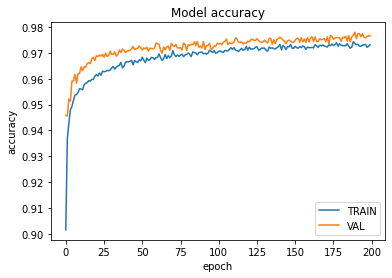

In [54]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

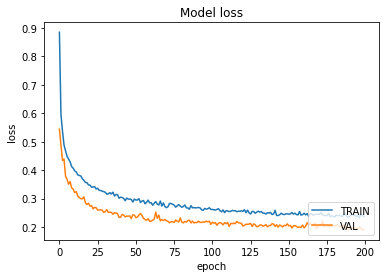

In [55]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [56]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

38/38 [==============================] - 0s 2ms/step - loss: 0.6113 - tp: 877.0000 - fp: 222.0000 - tn: 5808.0000 - fn: 329.0000 - accuracy: 0.9239 - precision: 0.7980 - recall: 0.7272 - auc: 0.9630 - prc: 0.8666


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.72      0.84       682
           1       0.58      0.91      0.71       297
           2       0.71      0.86      0.78       139
           3       0.43      0.35      0.38        57
           4       0.70      0.54      0.61        26
           5       0.33      0.60      0.43         5

    accuracy                           0.76      1206
   macro avg       0.62      0.66      0.62      1206
weighted avg       0.82      0.76      0.77      1206



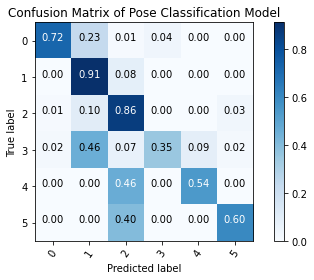

In [57]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

## No normalizing size

In [58]:
def normalize_pose_landmarks_norescale(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    return landmarks
def landmarks_to_embedding_norescale(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks_norescale(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

In [59]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding_norescale(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_5 (Reshape)            (None, 17, 3)        0           ['input_6[0][0]']                
                                                                                                  
 tf.__operators__.getitem_5 (Sl  (None, 17, 2)       0           ['reshape_5[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_20 (TFOpLa  (None, 2)           0           ['tf.__operators__.getitem_

In [60]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path` = "weights.best.hdf5"

checkpoint_path = "weights.best.801010split"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training


history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
581/603 [===========================>..] - ETA: 0s - loss: 0.2394 - tp: 9313.0000 - fp: 826.0000 - tn: 51684.0000 - fn: 1189.0000 - accuracy: 0.9680 - precision: 0.9185 - recall: 0.8868 - auc: 0.9905 - prc: 0.9645
Epoch 1: val_loss improved from inf to 0.19609, saving model to weights.best.801010split
INFO:tensorflow:Assets written to: weights.best.801010split/assets
603/603 [==============================] - 6s 7ms/step - loss: 0.2404 - tp: 9625.0000 - fp: 851.0000 - tn: 53399.0000 - fn: 1225.0000 - accuracy: 0.9681 - precision: 0.9188 - recall: 0.8871 - auc: 0.9905 - prc: 0.9645 - val_loss: 0.1961 - val_tp: 1111.0000 - val_fp: 71.0000 - val_tn: 5959.0000 - val_fn: 95.0000 - val_accuracy: 0.9771 - val_precision: 0.9399 - val_recall: 0.9212 - val_auc: 0.9946 - val_prc: 0.9799
Epoch 2/200
589/603 [============================>.] - ETA: 0s - loss: 0.2346 - tp: 8516.0000 - fp: 629.0000 - tn: 46491.0000 - fn: 908.0000 - accuracy: 0.9728 - precision: 0.9312 - recall: 0.9037 - au

Epoch 13/200
585/603 [============================>.] - ETA: 0s - loss: 0.2441 - tp: 8416.0000 - fp: 619.0000 - tn: 46181.0000 - fn: 944.0000 - accuracy: 0.9722 - precision: 0.9315 - recall: 0.8991 - auc: 0.9924 - prc: 0.9719
Epoch 13: val_loss did not improve from 0.19257
603/603 [==============================] - 2s 3ms/step - loss: 0.2444 - tp: 8673.0000 - fp: 639.0000 - tn: 47581.0000 - fn: 971.0000 - accuracy: 0.9722 - precision: 0.9314 - recall: 0.8993 - auc: 0.9924 - prc: 0.9717 - val_loss: 0.1965 - val_tp: 1109.0000 - val_fp: 67.0000 - val_tn: 5963.0000 - val_fn: 97.0000 - val_accuracy: 0.9773 - val_precision: 0.9430 - val_recall: 0.9196 - val_auc: 0.9946 - val_prc: 0.9802
Epoch 14/200
583/603 [============================>.] - ETA: 0s - loss: 0.2386 - tp: 8441.0000 - fp: 616.0000 - tn: 46024.0000 - fn: 887.0000 - accuracy: 0.9731 - precision: 0.9320 - recall: 0.9049 - auc: 0.9928 - prc: 0.9733
Epoch 14: val_loss did not improve from 0.19257
603/603 [===========================

Epoch 25/200
583/603 [============================>.] - ETA: 0s - loss: 0.2314 - tp: 8458.0000 - fp: 590.0000 - tn: 46050.0000 - fn: 870.0000 - accuracy: 0.9739 - precision: 0.9348 - recall: 0.9067 - auc: 0.9930 - prc: 0.9745
Epoch 25: val_loss did not improve from 0.19257
603/603 [==============================] - 2s 3ms/step - loss: 0.2339 - tp: 8738.0000 - fp: 610.0000 - tn: 47610.0000 - fn: 906.0000 - accuracy: 0.9738 - precision: 0.9347 - recall: 0.9061 - auc: 0.9928 - prc: 0.9737 - val_loss: 0.2012 - val_tp: 1107.0000 - val_fp: 77.0000 - val_tn: 5953.0000 - val_fn: 99.0000 - val_accuracy: 0.9757 - val_precision: 0.9350 - val_recall: 0.9179 - val_auc: 0.9945 - val_prc: 0.9797
Epoch 26/200
595/603 [============================>.] - ETA: 0s - loss: 0.2442 - tp: 8595.0000 - fp: 639.0000 - tn: 46961.0000 - fn: 925.0000 - accuracy: 0.9726 - precision: 0.9308 - recall: 0.9028 - auc: 0.9924 - prc: 0.9718
Epoch 26: val_loss did not improve from 0.19257
603/603 [===========================

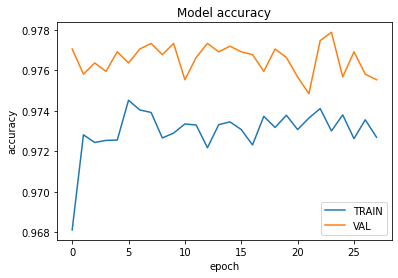

In [61]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

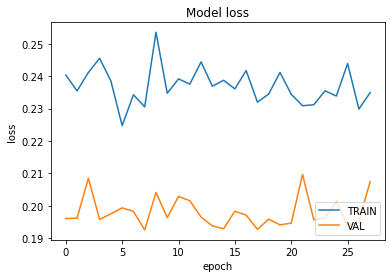

In [62]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [63]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

38/38 [==============================] - 0s 2ms/step - loss: 0.4999 - tp: 900.0000 - fp: 171.0000 - tn: 5859.0000 - fn: 306.0000 - accuracy: 0.9341 - precision: 0.8403 - recall: 0.7463 - auc: 0.9738 - prc: 0.9012


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.88       682
           1       0.69      0.88      0.77       297
           2       0.65      0.83      0.73       139
           3       0.31      0.37      0.34        57
           4       0.62      0.50      0.55        26
           5       0.33      1.00      0.50         5

    accuracy                           0.79      1206
   macro avg       0.60      0.73      0.63      1206
weighted avg       0.84      0.79      0.80      1206



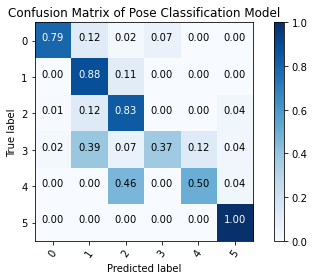

In [64]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

## No normalizing position

In [65]:
def normalize_pose_landmarks_noreposition(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
   # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks
def landmarks_to_embedding_norescale(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks_noreposition(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

In [66]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding_norescale(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model2 = keras.Model(inputs, outputs)
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_6 (Reshape)            (None, 17, 3)        0           ['input_7[0][0]']                
                                                                                                  
 tf.__operators__.getitem_6 (Sl  (None, 17, 2)       0           ['reshape_6[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_26 (TFOpLa  (None, 2)           0           ['tf.__operators__.getitem_

 tf.math.multiply_28 (TFOpLambd  ()                  0           ['tf.compat.v1.norm_4[0][0]']    
 a)                                                                                               
                                                                                                  
 tf.math.reduce_max_2 (TFOpLamb  ()                  0           ['tf.compat.v1.norm_5[0][0]']    
 da)                                                                                              
                                                                                                  
 tf.math.maximum_2 (TFOpLambda)  ()                  0           ['tf.math.multiply_28[0][0]',    
                                                                  'tf.math.reduce_max_2[0][0]']   
                                                                                                  
 tf.math.truediv_2 (TFOpLambda)  (None, 17, 2)       0           ['tf.__operators__.getitem_6[0][0
          

In [67]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path` = "weights.best.hdf5"

checkpoint_path = "weights.best.801010split"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training


history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
591/603 [============================>.] - ETA: 0s - loss: 0.2363 - tp: 9471.0000 - fp: 797.0000 - tn: 52513.0000 - fn: 1191.0000 - accuracy: 0.9689 - precision: 0.9224 - recall: 0.8883 - auc: 0.9915 - prc: 0.9680
Epoch 1: val_loss improved from inf to 0.20276, saving model to weights.best.801010split
INFO:tensorflow:Assets written to: weights.best.801010split/assets
603/603 [==============================] - 6s 7ms/step - loss: 0.2352 - tp: 9640.0000 - fp: 809.0000 - tn: 53441.0000 - fn: 1210.0000 - accuracy: 0.9690 - precision: 0.9226 - recall: 0.8885 - auc: 0.9916 - prc: 0.9683 - val_loss: 0.2028 - val_tp: 1105.0000 - val_fp: 81.0000 - val_tn: 5949.0000 - val_fn: 101.0000 - val_accuracy: 0.9748 - val_precision: 0.9317 - val_recall: 0.9163 - val_auc: 0.9941 - val_prc: 0.9794
Epoch 2/200
599/603 [============================>.] - ETA: 0s - loss: 0.2346 - tp: 8698.0000 - fp: 608.0000 - tn: 47312.0000 - fn: 886.0000 - accuracy: 0.9740 - precision: 0.9347 - recall: 0.9076 - a

Epoch 13/200
584/603 [============================>.] - ETA: 0s - loss: 0.2352 - tp: 8433.0000 - fp: 622.0000 - tn: 46098.0000 - fn: 911.0000 - accuracy: 0.9727 - precision: 0.9313 - recall: 0.9025 - auc: 0.9930 - prc: 0.9742
Epoch 13: val_loss did not improve from 0.18750
603/603 [==============================] - 2s 3ms/step - loss: 0.2355 - tp: 8709.0000 - fp: 642.0000 - tn: 47578.0000 - fn: 935.0000 - accuracy: 0.9727 - precision: 0.9313 - recall: 0.9030 - auc: 0.9930 - prc: 0.9741 - val_loss: 0.1944 - val_tp: 1107.0000 - val_fp: 76.0000 - val_tn: 5954.0000 - val_fn: 99.0000 - val_accuracy: 0.9758 - val_precision: 0.9358 - val_recall: 0.9179 - val_auc: 0.9951 - val_prc: 0.9815
Epoch 14/200
584/603 [============================>.] - ETA: 0s - loss: 0.2386 - tp: 8464.0000 - fp: 610.0000 - tn: 46110.0000 - fn: 880.0000 - accuracy: 0.9734 - precision: 0.9328 - recall: 0.9058 - auc: 0.9929 - prc: 0.9732
Epoch 14: val_loss did not improve from 0.18750
603/603 [===========================

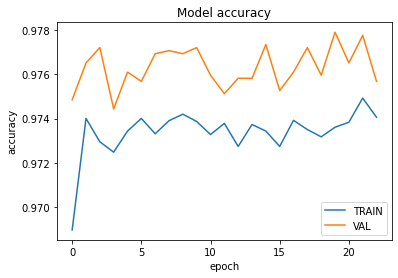

In [68]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

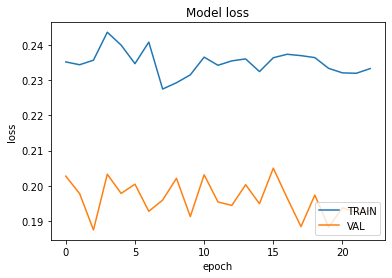

In [69]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [70]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

38/38 [==============================] - 0s 2ms/step - loss: 0.6032 - tp: 889.0000 - fp: 227.0000 - tn: 5803.0000 - fn: 317.0000 - accuracy: 0.9248 - precision: 0.7966 - recall: 0.7371 - auc: 0.9644 - prc: 0.8686


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.73      0.84       682
           1       0.57      0.92      0.71       297
           2       0.70      0.84      0.77       139
           3       0.54      0.33      0.41        57
           4       0.67      0.54      0.60        26
           5       0.40      0.80      0.53         5

    accuracy                           0.77      1206
   macro avg       0.65      0.69      0.64      1206
weighted avg       0.83      0.77      0.77      1206



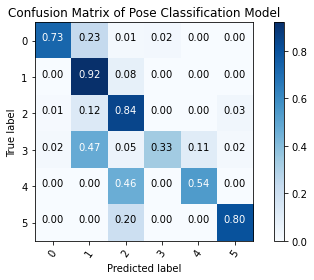

In [71]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))